In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, "../src")

In [6]:
import os
import sys
import os.path as osp

import dill
import time
from tqdm.notebook import tqdm as tqdmn
from argparse import ArgumentParser
from easydict import EasyDict as edict

import numpy as onp

import jax
from jax.random import split
from jax import (
    jit,
    vmap,
    random,
    partial,
    tree_map,
    numpy as jnp,
    value_and_grad,
)

import optax as ox
import haiku as hk

from lib import (
    apply_and_loss_fn,
    
    flatten,
    outer_loop,
    setup_device,
    fsl_inner_loop,
    batched_outer_loop,
    parse_and_build_cfg,
    mean_xe_and_acc_dict,
    # outer_loop_reset_per_task,
)
from data import prepare_data
from experiment import Experiment, Logger
from data.sampling import fsl_sample_transfer_build, BatchSampler
from models.maml_conv import miniimagenet_cnn_argparse, prepare_model, make_params

from test_sup import test_sup_cosine
from test_utils import test_fsl_embeddings

TRAIN_SIZE = 500

In [7]:
cfg = edict()

In [9]:
cfg.dataset = "miniimagenet"
cfg.data_dir = "/Users/sebamenabar/Documents/datasets/mini-imagenet/"

In [20]:
cpu, device = setup_device(0)
rng = random.PRNGKey(0)

In [10]:
train_images, train_labels, val_images, val_labels, preprocess_fn = prepare_data(
    cfg.dataset, cfg.data_dir, device,
)
fsl_train_images = train_images[:, :TRAIN_SIZE]
fsl_train_labels = train_labels[:, :TRAIN_SIZE]
# These are for supervised learning validation
sup_val_images = flatten(train_images[:, TRAIN_SIZE:], 1)
sup_val_labels = flatten(train_labels[:, TRAIN_SIZE:], 1)

transfer_spt_images = flatten(val_images[:, :TRAIN_SIZE], (0, 1))
transfer_spt_labels = flatten(val_labels[:, :TRAIN_SIZE], (0, 1))
transfer_qry_images = flatten(val_images[:, TRAIN_SIZE:], (0, 1))
transfer_qry_labels = flatten(val_labels[:, TRAIN_SIZE:], (0, 1))

print("Supervised train data:", fsl_train_images.shape, fsl_train_labels.shape)
print(
    "Supervised validation data:", sup_val_images.shape, sup_val_labels.shape,
)
print(
    "FSL and Transfer learning data:", val_images.shape, val_labels.shape,
)
print("Transfer", transfer_spt_images.shape, transfer_spt_labels.shape, transfer_qry_images.shape, transfer_qry_labels.shape)

Supervised train data: (64, 500, 84, 84, 3) (64, 500)
Supervised validation data: (6400, 84, 84, 3) (6400,)
FSL and Transfer learning data: (16, 600, 84, 84, 3) (16, 600)
Transfer (8000, 84, 84, 3) (8000,) (1600, 84, 84, 3) (1600,)


In [12]:
import matplotlib.pyplot as plt

In [ ]:
def _random_crop_single_image(rng, img, out=84, padding=None):
    """
        args:
        imgs: np.array shape (B,C,H,W)
        out: output size (e.g. 84)
        returns np.array
    """
    rng_w, rng_h = split(rng)
    h, w, c = img.shape
    crop_max = h - out + 1
    w1 = np.random.randint(0, crop_max, n)
    h1 = np.random.randint(0, crop_max, n)
    cropped = np.empty((n, out, out, c), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        
        cropped[i] = img[:, h11:h11 + out, w11:w11 + out]
    return cropped

In [22]:
random.randint(rng, 0, 84)

TypeError: randint() missing 1 required positional argument: 'maxval'

In [ ]:
def random_crop(rng, img, out=84, padding=None):
    if padding:
        img = jnp.pad(img, padding)
    h, w, c = imgs.shape
    crop_max = h - out + 1
    w1 = random.randint(0, crop_max, n)
    h1 = np.random.randint(0, crop_max, n)
    cropped = np.empty((n, out, out, c), dtype=imgs.dtype)

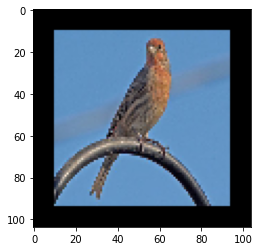

In [17]:
plt.imshow(jnp.pad(fsl_train_images[0, 0], ((10, 10), (10, 10), (0, 0))))